In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import integrate as inte
from astropy import units as u
from astropy import constants as const
import pandas as pd
import xarray as xr

In [87]:
#constants and units
H0 = 67.9 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)

Rate = 30.0 /(u.Gpc**3 * u.year)

## Calculate $\Omega_{GW}$ 
$ \rho_c c^2 \Omega_{GW} (f) = \frac{(f \pi G)^{2/3}}{3} \mathcal{R_0} \mathcal{M}^{5/3} \int_0^{z_f} \frac{\mathrm{d}z}{(1+z)^{4/3} H(z)} \text{(z-evo)} $

where $ \text{z-evo} = \mathcal{C}(\alpha,\beta,z_p) \frac{(1+z)^{\alpha}}{1 + (\frac{1+z}{1+z_p})^{\alpha+\beta}} $ is the redshift evolution of the merger rate.

In [176]:
#redshift evolution
def int_over_z(z,Omega_m,Omega_Lam,Omega_r, zp=0,alpha=0,beta=0):
    ''' putting in values for zp, alpha, and beta gives the redshift evolution in Callister et al 2020'''
    Omega_k = 1 - (Omega_m + Omega_Lam + Omega_r)
    H_z = np.sqrt(Omega_Lam + Omega_r * (1 + z)**4. + Omega_m * (1 + z)**3. + Omega_k * (1 + z)**2. )
    
    z_evo = np.power(1+z,alpha)/(1+ np.power((1+z)/(1+zp),beta+alpha))
    C = 1 + np.power(1+zp,-1*(alpha+beta))
    
    integrand = z_evo * C / (H_z*np.power(1+z,4./3.))
    return integrand

In [79]:
#--- get all z-evos for different peak reshift and rising power law ---#
zp_array = np.linspace(0,5)
alpha_arr = np.linspace(-20,20)
z_int_arr = np.zeros((len(zp_array),len(alpha_arr))) / H0.unit

for z in range(len(zp_array)):
    for a in range(len(alpha_arr)):
        z_params = [zp_array[z], alpha_arr[a], 3.] #beta=3 always
        z_int = inte.quad(int_over_z,0,10.,
                         args=(0.3, 0.7,0,z_params[0],
                               z_params[1],z_params[2])
                        )[0]
        z_int *= 1./H0
        z_int_arr[z,a] = z_int

## Convert from $\Omega_{GW}$ to Optimal SNR

$ <S/N>_{opt}^2 = 2 T (\frac{3H_O^2}{10\pi^2})^2 \int_0^\infty df \frac{\gamma^2(f) \Omega_{GW}^2(f)}{f^6 P_1(f) P_2(f)}  $ 

where $\gamma(f)$ is the overlap reduction function, $\Omega_{GW} \propto f^{2/3}$ and $P_i (f)$ are the PSDs of each of the two LIGO detectors.

Plugging in $\Omega_{GW}$ from above yields

$<S/N>_{opt} = (\pi G)^{2/3} \frac{\mathcal{R}_0 \mathcal{M}^{5/3}}{\rho_c c^2} \text{(z-evo)} \frac{H_0^2}{10 \pi^2} \sqrt{2 T \int_0^\infty df \frac {f^{-14/3} \gamma^2(f)}{P_1(f) P_2(f)} }$

In [192]:
def overlap_reduction(f):
    if f < 250:
        olr = olr_below
    else:
        olr = olr_above
    return np.interp(f,olr[:,0],olr[:,1])

def f_integrand(f,obs_run):
    overlap = overlap_reduction(f) **2. 
    freq_power = np.power(f,-14./3.)
    if obs_run == 'O1':
        PH = PSD_O1_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O1_xr.sel(freq=f,method='nearest').Livingston
    elif obs_run== 'O2':
        PH = PSD_O2_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O2_xr.sel(freq=f,method='nearest').Livingston
        
    return overlap * freq_power / (PH * PL)

I get PSDs $P_1$ and $P_2$ from the Livingston and Hanford's "representative best" strain curves from O1 and O2. The PSD is the square of the strain curve (as far as I know, at least). Links here: 

H1+L1 sensitivity spectra, representative best of O2: https://dcc.ligo.org/LIGO-P1800374/public

H1 sensitivity spectra, representative of O1: https://dcc.ligo.org/LIGO-G1600150/public

L1 sensitivity spectra, representative of O1: https://dcc.ligo.org/LIGO-G1600151/public



I get the overlap reduction function $\gamma$ by digitizing the curves in Figure 2 of Allen+Romano 1999. Link here: https://journals.aps.org/prd/abstract/10.1103/PhysRevD.59.102001

In [16]:
#--- load in external datasets ---#
olr_below = np.genfromtxt("data/overlap_reduction_below_200hz.csv",delimiter=',')
olr_below=olr_below[:-2]
olr_above=np.genfromtxt("data/overlap_reduction_above_200hz.csv",delimiter=',')

PSD_O1 = pd.DataFrame()
PSD_O1['freq'] = np.genfromtxt("data/2015_10_24_15_09_43_H1_O1_strain.txt")[:,0]
    #strains are the sqrt of the PSD
PSD_O1['Hanford'] = np.power(np.genfromtxt("data/2015_10_24_15_09_43_H1_O1_strain.txt")[:,1],2.) 
PSD_O1['Livingston'] = np.power(np.genfromtxt("data/2015_10_24_15_10_43_L1_O1_strain.txt")[:,1],2.)

PSD_O1_xr = xr.Dataset.from_dataframe(PSD_O1.set_index('freq'))

PSD_O2 = pd.DataFrame()
PSD_O2['freq'] = np.genfromtxt("data/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt")[:,0]
PSD_O2['Hanford'] =  np.power(np.genfromtxt("data/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt")[:,1],2.)
PSD_O2['Livingston'] =  np.power(np.genfromtxt("data/2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt")[:,1],2.)

PSD_O2_xr = xr.Dataset.from_dataframe(PSD_O2.set_index('freq'))

In [193]:
#--- set constants ---#
#O1: September 12, 2015 to January 19, 2016
days_in_O1 = len(pd.date_range(start='09-12-2015',end='01-19-2016',freq='D')) * u.day - 14*u.day

#O2: November 30, 2016 to August 25, 2017
days_in_O2 = len(pd.date_range(start='11-30-2016',end='08-25-2017',freq='D')) * u.day - 28 *u.day

#componets of expression for SNR
prefac_inner_prod = ( 3 * H0**2. / (10 * np.pi**2.))
# f_integral_O1 = inte.quad(f_integrand, 1.5,6e3,args='O1', limit=200
#                          )[0] * (u.s)**3 * (u.Hz)**(4./3)
# f_integral_O2 = inte.quad(f_integrand, 1.5,6e3,args='O2', limit=200
#                          )[0] * (u.s)**3 * (u.Hz)**(4./3)

f_integral_O1 = inte.quad(f_integrand, 2.003e1,1.72e3,args='O1', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)
f_integral_O2 = inte.quad(f_integrand, 2.003e1,1.72e3,args='O2', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)


#components of expression for Omega_GW
Mchirp = 13.05 * u.Msun #30.* u.Msun
rhoc2 = ( c**2. ) * ( H0**2. ) * 3. /( 8. * np.pi * G )

prefac_omegaGW = np.power(np.pi*G,2./3.) * Rate * np.power(Mchirp,5./3.) * z_int_arr / rhoc2

Total SNR adds in quadrature from O1 and O2
$S/N_{total} = S/N_{O1} + S/N_{O2} \propto \sqrt{T_{O1}} + \sqrt{T_{O2}} $

In [194]:
rho_opt_O1 = prefac_inner_prod * prefac_omegaGW * np.sqrt(2 * days_in_O1 * f_integral_O1)
rho_opt_O2 = prefac_inner_prod * prefac_omegaGW * np.sqrt(2 * days_in_O2 * f_integral_O2)
SNR_arr = np.sqrt(rho_opt_O1**2+rho_opt_O2**2).to(u.m/u.m)

#### Plot in the same style and with the same limits so as to make an easy comparison

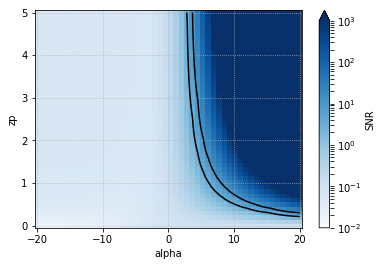

In [195]:
SNR_xr = xr.DataArray(SNR_arr,
                        dims = ('zp','alpha'),
                        coords = (zp_array,alpha_arr),
                        name = 'SNR')
SNR_xr.plot(norm=LogNorm(vmin=1e-2,vmax=1e3),cmap='Blues')
SNR_xr.plot.contour(levels=[3,10],colors='black')
plt.grid(linestyle=':')
plt.show()

#### Look at SNR where $\alpha=10, z_p=1$

In [191]:
print(SNR_xr.sel({'alpha':10,'zp':1},method='nearest'))

<xarray.DataArray 'SNR' ()>
array(184.514463)
Coordinates:
    zp       float64 1.02
    alpha    float64 10.2


I find that at $z_{peak}= 1, \alpha=10$, I get an SNR of ~238, whereas figure 2 of S+M seems to get SNR=3

## Appendix: Alternate integration

I get a warning message when I use scipy.integrate.quad(), I think because the PSDs have too many values for the integrator to work with order 100 samples. TI checked and the integration error is only one order of magnitude lower than the actual value. So I try it a different way that uses all of the values in the PSDs.

In [34]:
f_integrand_arr = (np.power(PSD_O2_xr.freq, -14./3.) \
                   * np.interp(PSD_O2_xr.freq,olr_above[:,0],olr_above[:,1]) **2. \
                  )/ (PSD_O2_xr.Hanford * PSD_O2_xr.Livingston)
f_integral_O2_tz = inte.trapz(f_integrand_arr) * (u.s)**3 * (u.Hz)**(4./3)

f_integrand_arr = (np.power(PSD_O1_xr.freq, -14./3.) \
                   * np.interp(PSD_O1_xr.freq,olr_above[:,0],olr_above[:,1]) **2. \
                  ) / (PSD_O1_xr.Hanford * PSD_O1_xr.Livingston)
f_integral_O1_tz = inte.trapz(f_integrand_arr) * (u.s)**3 * (u.Hz)**(4./3)

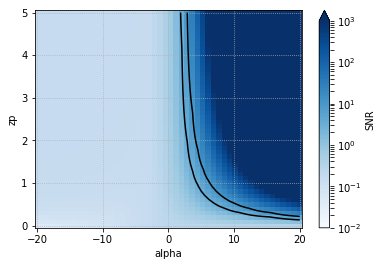

<xarray.DataArray 'SNR' ()>
array(136.844911)
Coordinates:
    zp       float64 1.02
    alpha    float64 10.2


In [36]:
rho_opt_O1 = prefac_inner_prod * prefac_omegaGW * np.sqrt(
    2 * days_in_O1 * f_integral_O1_tz)
rho_opt_O2 = prefac_inner_prod * prefac_omegaGW * np.sqrt(
    2 * days_in_O2 * f_integral_O2_tz)
SNR_arr = np.sqrt(rho_opt_O1**2.+rho_opt_O2**2.).to(u.m/u.m)

SNR_xr = xr.DataArray(SNR_arr,
                        dims = ('zp','alpha'),
                        coords = (zp_array,alpha_arr),
                        name = 'SNR')
SNR_xr.plot(norm=LogNorm(vmin=1e-2,vmax=1e3),cmap='Blues')
SNR_xr.plot.contour(levels=[3,10],colors='black')
plt.grid(linestyle=':')
plt.show()

print(SNR_xr.sel({'alpha':10,'zp':1},method='nearest'))

This doesn't help and actually makes the disagreement slightly worse! :(

## Appendix: Cross-checks across mine and Tom's code

In [29]:
#are we using the same chirp mass?
MsunToSec = G/np.power(c,3.)
eta = 0.25
Mtot=30. *u.Msun
fMerge = (0.29740*eta**2. + 0.044810*eta + 0.095560)/(np.pi*Mtot*MsunToSec)
print(fMerge.to(u.Hz)**(2./3))

Mc = np.power(eta,3./5.)*Mtot
print Mc
amp = np.power(G*np.pi,2./3.)*np.power(Mc,5./3.)/3.
print amp

41.7691150856 Hz(2/3)
13.0582584494 solMass
0.000136954193713 km(4/3) Mpc(2/3) solMass / s(4/3)


In [48]:
f_integral_O1 = inte.quad(f_integrand, 1.5,6e3,args='O1', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)
f_integral_O2 = inte.quad(f_integrand, 1.5,6e3,args='O2', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)

print 'my integration limits: ', f_integral_O1, f_integral_O2

f_integral_O1 = inte.quad(f_integrand, 20,1.72e3,args='O1', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)
f_integral_O2 = inte.quad(f_integrand, 20, 1.72e3,args='O2', limit=200
                         )[0] * (u.s)**3 * (u.Hz)**(4./3)

print 'using toms "lowFreqs" :' ,  f_integral_O1, f_integral_O2


my integration limits:  4.82602787056e+83 Hz(4/3) s3 2.08583250304e+84 Hz(4/3) s3
using toms "lowFreqs" : 5.47292115009e+83 Hz(4/3) s3 2.08444619961e+84 Hz(4/3) s3


so its off by 10% max

In [46]:
#what are my potential limits of integration?
PSD_O1_xr.freq
#cool i have data up to 6e3 Hz

<xarray.DataArray 'freq' (freq: 47921)>
array([  10.   ,   10.125,   10.25 , ..., 5999.75 , 5999.875, 6000.   ])
Coordinates:
  * freq     (freq) float64 10.0 10.12 10.25 10.38 ... 6e+03 6e+03 6e+03 6e+03

In [123]:
#is the approximation of dEdf \propto f^-1/3 always (i.e. inspiral dominates) the problem?

year = 365.25*24*3600.
Mpc = 3.09e16*1e6
Gpc = Mpc*1e3
Msun = 1.99e30
c = 2.998e8
G = 6.67e-11
MsunToSec = Msun*G/np.power(c,3.)
OmgM = 0.31
OmgL = 0.69
H0 = 67.7*(10.**3.)/Mpc # SI units
R0_example = 50./year/np.power(1.e3,3) # 1/Gpc^3/s converted to 1/Mpc^3/s
rhoC = 3.*np.power(H0*c,2.)/(8.*np.pi*G)*np.power(Mpc,3.) # Converted to J/Mpc^3

def dEdf(Mtot,freqs,eta=0.25):

    # Define IMR parameters
    fMerge = (0.29740*eta**2. + 0.044810*eta + 0.095560)/(np.pi*Mtot*MsunToSec)
    fRing = (0.59411*eta**2. + 0.089794*eta + 0.19111)/(np.pi*Mtot*MsunToSec)
    fCut = (0.84845*eta**2. + 0.12828*eta + 0.27299)/(np.pi*Mtot*MsunToSec)
    sigma = (0.50801*eta**2. + 0.077515*eta + 0.022369)/(np.pi*Mtot*MsunToSec)

    # Initialize energy density, identify piecewise components
    dEdf_spectrum = np.zeros(freqs.shape)
    inspiral = freqs<fMerge
    merger = (freqs>=fMerge)*(freqs<fRing)
    ringdown = (freqs>=fRing)*(freqs<fCut)

    # Fill
    dEdf_spectrum[inspiral] = np.power(freqs[inspiral],-1./3.)
    dEdf_spectrum[merger] = np.power(freqs[merger],2./3.)/fMerge
    dEdf_spectrum[ringdown] = np.square(freqs[ringdown]/(1.+np.square((freqs[ringdown]-fRing)/(sigma/2.))))/(fMerge*fRing**(4./3.))

    # Normalization
    Mc = np.power(eta,3./5.)*Mtot*Msun
    amp = np.power(G*np.pi,2./3.)*np.power(Mc,5./3.)/3.

    return amp*dEdf_spectrum

def dEdf_inspiral(Mtot,freqs,eta=0.25):
    Mc = np.power(eta,3./5.)*Mtot*Msun
    amp = np.power(G*np.pi,2./3.)*np.power(Mc,5./3.)/3.
    return amp* np.power(freqs,-1./3.)

def dPdz(zs,alpha,beta,zp):
    pzs = np.power(1.+zs,alpha)/(1.+np.power((1.+zs)/(1.+zp),alpha+beta))
    pzs /= pzs[0]
    return pzs

def OmegaGW_tom(R0,alpha,beta,zp,freqs,dedf_func):

    zs = np.arange(0.,10.,0.05)
    dz = zs[1]-zs[0]

    # Evaluate energy density of singe object
    redshiftedFreqs = np.array([freqs*(1.+z) for z in zs])
    print redshiftedFreqs.shape
    dedf = dedf_func(30.,redshiftedFreqs).T
    print dedf.shape
    
    # Redshift integrand
    R_invE = R0*dPdz(zs,alpha,beta,zp)/np.sqrt(OmgM*(1.+zs)**3.+OmgL)/(1.+zs)
    print R_invE.shape

    # Convert to energy density
    Omg_spectrum = (freqs/rhoC/H0)*dedf.dot(R_invE)*dz #this is an integral over redshift
    print dedf.dot(R_invE).shape
    return Omg_spectrum

Ogw_tom = OmegaGW_tom(30./1e9/year,10.,3.,1.,freqs_stoch,dEdf)
Ogw_tom_inspiral = OmegaGW_tom(30./1e9/year,10.,3.,1.,freqs_stoch,dEdf_inspiral)

(200L, 47629L)
(47629L, 200L)
(200L,)
(47629L,)
(200L, 47629L)
(47629L, 200L)
(200L,)
(47629L,)


In [179]:
H0 = 67.7 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)

Rate = 30.0 /(u.Gpc**3 * u.year)

#my func, but using the chirp mass Tom seems to inadvertently use
def one_chirp_mass():
    '''instead of a distribution in mass, we just pretend all systems have equal mass components 
    and chirp mass 30 Msun'''
    Mchirp = Mc #13.05 - calculated 2 cells up
    massfac = np.power(Mchirp,5./3.)
    return massfac

def OmegaGW_mine_w_tom_signature(R0,alpha,beta,zp,freqs):
    fpiG = np.power(freqs*np.pi*G,2./3)/3. #* freqs
    rhoc2 = ( c**2 ) * ( H0**2 ) * 3 /( 8 * np.pi * G )
    massfac = one_chirp_mass().value * np.power(u.Msun,5./3)
    Omega_m=0.31
    integral = inte.quad(int_over_z,0,1e3,
                         args=(Omega_m, 1-Omega_m,0,zp,
                               alpha,beta)
                        )[0]
#     zs = np.arange(0.,10.,0.05)
#     dz = zs[1]-zs[0]
#     redshiftedFreqs = np.array([freqs.value*(1.+z) for z in zs]).T * u.Hz
#     integral = np.power(redshiftedFreqs,-1./3.).dot(int_over_z(zs,Omega_m, 1-Omega_m,0,zp,alpha,beta)) * dz
    
    integral *= 1./H0
    
    return (integral * R0 * massfac * fpiG / rhoc2).to(u.m/u.m)
Ogw_me = OmegaGW_mine_w_tom_signature(Rate,10.,3.,1.,freqs_stoch*u.Hz)

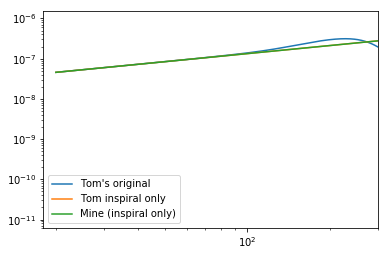

4.56598469867e-08 4.567668940857554e-08


In [180]:
plt.plot(freqs_stoch,Ogw_tom,label="Tom's original")
plt.plot(freqs_stoch,Ogw_tom_inspiral,label="Tom inspiral only")
plt.plot(freqs_stoch,Ogw_me,label='Mine (inspiral only)')
plt.xlim(18,300)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()
print Ogw_me[0], Ogw_tom_inspiral[0]
#mine and his with just inspiral have the same power, just a different scale

Ok so this is a huge difference, but is it relevant once we switch to SNR?

In [174]:
#try to use the sigma data Tom uses - seems to be sigma=PSD/olr_func

# Import stochastic data
freqs_O1,C_O1,sigma_O1 = np.loadtxt('./data/Cf_O1.dat',unpack=True,skiprows=1)
freqs_O2,C_O2,sigma_O2 = np.loadtxt('./data/Cf_O2.dat',unpack=True,skiprows=1)

# Combine
C_stoch = (C_O1/sigma_O1**2. + C_O2/sigma_O2**2.)/(1./sigma_O1**2. + 1./sigma_O2**2.)
sigma_stoch = 1./np.sqrt(1./sigma_O1**2. + 1./sigma_O2**2.)
sigma2_stoch = np.power(sigma_stoch,2.)
freqs_stoch = freqs_O2

# Select only frequencies with data
goodInds = np.where(C_stoch==C_stoch)
freqs_stoch = freqs_stoch[goodInds]
sigma2_stoch = sigma2_stoch[goodInds]

#my units
H0 = 67.9 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)

Rate = 30.0 /(u.Gpc**3 * u.year)

#toms snr converter
beta = 3.
OmgGW = OmegaGW_mine_w_tom_signature(Rate,10.,3.,1.,freqs_stoch*u.Hz)
my_snr = np.sqrt(np.sum(np.power(OmgGW,2.)/sigma2_stoch)) 

#toms units
year = 365.25*24*3600.
Mpc = 3.09e16*1e6
Gpc = Mpc*1e3
Msun = 1.99e30
c = 2.998e8
G = 6.67e-11
MsunToSec = Msun*G/np.power(c,3.)
OmgM = 0.31
OmgL = 0.69
H0 = 67.7*(10.**3.)/Mpc # SI units
R0_example = 50./year/np.power(1.e3,3) # 1/Gpc^3/s converted to 1/Mpc^3/s
rhoC = 3.*np.power(H0*c,2.)/(8.*np.pi*G)*np.power(Mpc,3.) # Converted to J/Mpc^3
OmgGW = OmegaGW_tom(30./1e9/year,10.,3.,1.,freqs_stoch,dEdf)
tom_snr = np.sqrt(np.sum(np.power(OmgGW,2.)/sigma2_stoch))
OmgGW = OmegaGW_tom(30./1e9/year,10.,3.,1.,freqs_stoch,dEdf_inspiral)
tom_snr_inspiral = np.sqrt(np.sum(np.power(OmgGW,2.)/sigma2_stoch))

C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in divide
C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in divide


(200L, 47629L)
(47629L, 200L)
(200L,)
(47629L,)
(200L, 47629L)
(47629L, 200L)
(200L,)
(47629L,)


In [175]:
print my_snr, tom_snr_inspiral, tom_snr

3.42154898042 3.4510802975686246 3.458023077304556


Yayuhhh. I think small differences are b/c of constants. now for The Latest Figure

In [182]:
zp_array = np.linspace(0,5)
alpha_arr = np.linspace(-20,20)
SNR_arr = np.zeros((len(zp_array),len(alpha_arr)))

for z in range(len(zp_array)):
    for a in range(len(alpha_arr)):
        z_params = [zp_array[z], alpha_arr[a], 3.] #beta=3 always
        
        OmgGW = OmegaGW_mine_w_tom_signature(Rate,z_params[1],z_params[2],z_params[0],freqs_stoch*u.Hz)
        my_snr = np.sqrt(np.sum(np.power(OmgGW,2.)/sigma2_stoch))
        SNR_arr[z,a] = my_snr

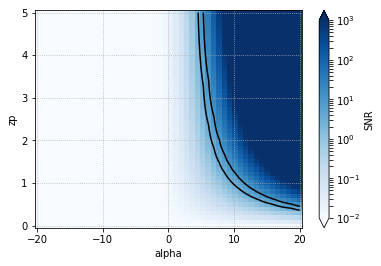

In [183]:
SNR_xr = xr.DataArray(SNR_arr,
                        dims = ('zp','alpha'),
                        coords = (zp_array,alpha_arr),
                        name = 'SNR')
SNR_xr.plot(norm=LogNorm(vmin=1e-2,vmax=1e3),cmap='Blues')
SNR_xr.plot.contour(levels=[3,10],colors='black')
plt.grid(linestyle=':')
plt.show()

In [184]:
print(SNR_xr.sel({'alpha':10,'zp':1},method='nearest'))

<xarray.DataArray 'SNR' ()>
array(4.314389)
Coordinates:
    zp       float64 1.02
    alpha    float64 10.2


yayyyyy its completely identical